# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

## 0. Get setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1
torchvision version: 0.20.1


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/Users/mdashikadnan/Documents/adnanedu/python/ztm/pytorch/pytorch-ztm/pytorch-deep-learning/pytorch_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!ls going_modular/going_modular

README.md        data_setup.py    model_builder.py train.py
__pycache__      engine.py        predictions.py   utils.py


In [4]:
# Setup device agnostic code
def set_device():

    if torch.cuda.is_available():

        device = torch.device("cuda")

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():

        device = torch.device("mps")

    else:

        device = torch.device("cpu")

    return device

device = set_device()
print(f"Using device: {device}")

Using device: mps


## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [5]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline


### 3 questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
    * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Creating an EffNetB2 feature extractor

Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [7]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters(): # PyTorch won't track the gradient of parameters of effnetb2
  param.requires_grad = False

In [8]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [9]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))

In [11]:
# Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [12]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [13]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [14]:

# from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 288, 288),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.2 Creating DataLoaders for EffNetB2

In [15]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn, 
                                device=device)

 10%|█         | 1/10 [01:18<11:42, 78.08s/it]

Epoch: 1 | train_loss: 0.9817 | train_acc: 0.5729 | test_loss: 0.7343 | test_acc: 0.9625


 20%|██        | 2/10 [02:32<10:09, 76.20s/it]

Epoch: 2 | train_loss: 0.7070 | train_acc: 0.8667 | test_loss: 0.5739 | test_acc: 0.9500


 30%|███       | 3/10 [03:49<08:53, 76.19s/it]

Epoch: 3 | train_loss: 0.6039 | train_acc: 0.8167 | test_loss: 0.4819 | test_acc: 0.9625


 40%|████      | 4/10 [05:05<07:37, 76.26s/it]

Epoch: 4 | train_loss: 0.4490 | train_acc: 0.9021 | test_loss: 0.4318 | test_acc: 0.9375


 50%|█████     | 5/10 [06:22<06:22, 76.52s/it]

Epoch: 5 | train_loss: 0.4287 | train_acc: 0.9104 | test_loss: 0.3894 | test_acc: 0.9472


 60%|██████    | 6/10 [07:39<05:06, 76.55s/it]

Epoch: 6 | train_loss: 0.4202 | train_acc: 0.8833 | test_loss: 0.3528 | test_acc: 0.9688


 70%|███████   | 7/10 [08:53<03:47, 75.99s/it]

Epoch: 7 | train_loss: 0.4224 | train_acc: 0.8396 | test_loss: 0.3256 | test_acc: 0.9472


 80%|████████  | 8/10 [10:09<02:31, 75.86s/it]

Epoch: 8 | train_loss: 0.3951 | train_acc: 0.8875 | test_loss: 0.3461 | test_acc: 0.9472


 90%|█████████ | 9/10 [11:26<01:16, 76.08s/it]

Epoch: 9 | train_loss: 0.3832 | train_acc: 0.8771 | test_loss: 0.3104 | test_acc: 0.9347


100%|██████████| 10/10 [12:41<00:00, 76.10s/it]

Epoch: 10 | train_loss: 0.3655 | train_acc: 0.8604 | test_loss: 0.2837 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

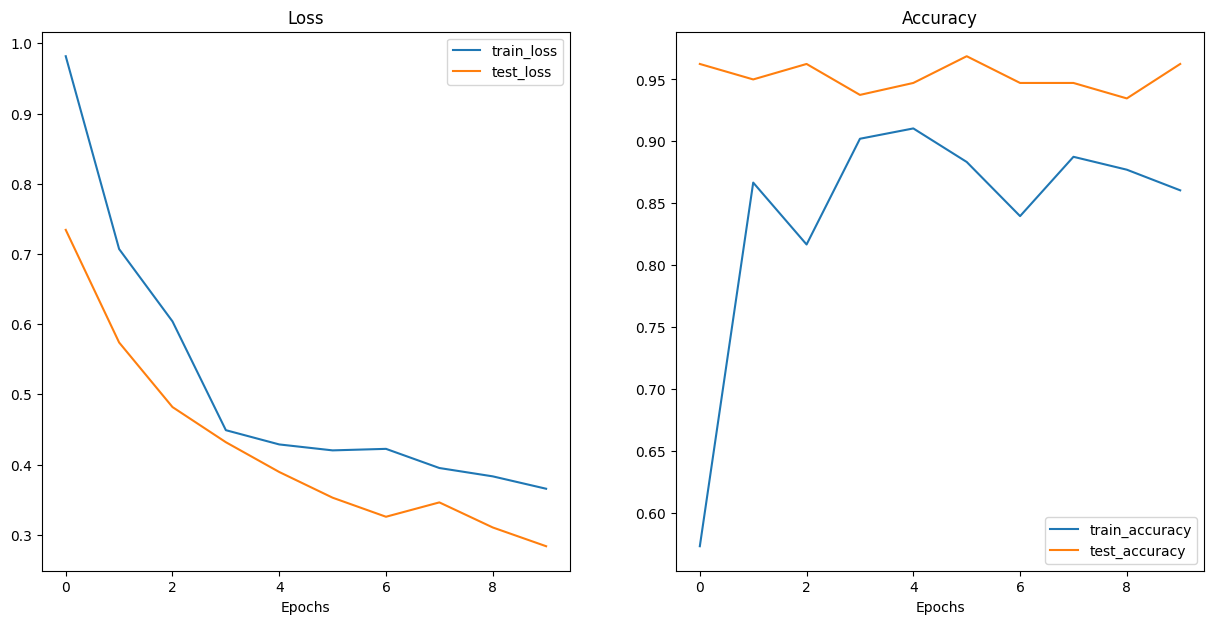

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [19]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [20]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [21]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = { "test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size
}
effnetb2_stats

{'test_loss': 0.28366083800792696,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.85711097717285}

### 4. Creating a ViT feature extractor

In [23]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:

def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768, 
                                        out_features=num_classes))
  
  return model, transforms

In [25]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [26]:
# from torchinfo import summary

# # Print ViT model summary (uncomment for full output) 
# summary(vit, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for ViT feature extractor

In [27]:
# Setup ViT DataLoaders 
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor

We're up to model experiment number two: a ViT feature extractor.

In [28]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device)

 10%|█         | 1/10 [01:23<12:28, 83.17s/it]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


 20%|██        | 2/10 [02:46<11:07, 83.44s/it]

Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602


 30%|███       | 3/10 [04:10<09:45, 83.59s/it]

Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693


 40%|████      | 4/10 [05:34<08:23, 83.85s/it]

Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722


 50%|█████     | 5/10 [06:57<06:57, 83.59s/it]

Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784


 60%|██████    | 6/10 [08:21<05:34, 83.70s/it]

Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722


 70%|███████   | 7/10 [09:44<04:10, 83.51s/it]

Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784


 80%|████████  | 8/10 [11:08<02:46, 83.40s/it]

Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722


 90%|█████████ | 9/10 [12:30<01:23, 83.05s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784


100%|██████████| 10/10 [13:53<00:00, 83.35s/it]

Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

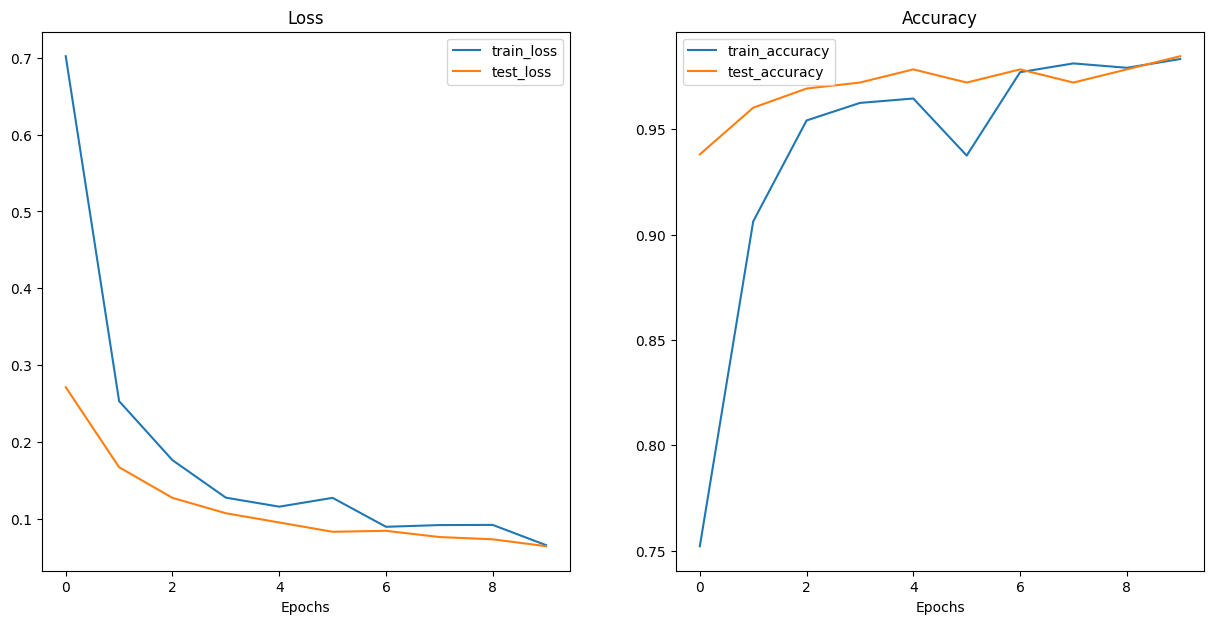

In [29]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT Feature Extractor

In [30]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [31]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327.3689556121826 MB


### 4.6 Collecting ViT feature extractor stats

In [32]:
# Count number of parameters in ViT 
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [33]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

In [34]:
vit_stats

{'test_loss': 0.06443447121419013,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3689556121826}

## 5. Making predictions with our trained models and timing them 

**Our goal:**

1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:

1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.

In [35]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

### 5.1 Creating a function to make across the test dataset

Steps to create pred_and_store():

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.

2. Create an empty list (can return a full list of all predictions later).

3. Loop through the target input paths (the rest of the steps will take place inside the loop).

4. Create an empty dictionary for each sample (prediction statistics will go in here).

5. Get the sample path and ground truth class from the filepath.

6. Start the prediction timer.

7. Open the image using PIL.Image.open(path).

8. Transform the image to be usable with a given model.

9. Prepare the model model for inference by sending to the target device and turning on eval() mode.

10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.

11. Add the pred prob + pred class to empty dictionary from step 4.

12. End the prediction timer started in step 6 and add the time to the prediction dictionary.

13. See if the predicted class matches the ground truth class.

14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.

15. Return the list of prediction dictionaries.

In [36]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer # https://docs.python.org/3/library/timeit.html#timeit.default_timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str) -> List[Dict]:
    # 2. Create an empty list (can return a full list of all predictions later). 
    pred_list = []

    # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
    for path in tqdm(paths):
        # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
        pred_dict = {}

        # 5. Get the sample path and ground truth class from the filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer.
        start_time = timer()

        # 7. Open the image using PIL.Image.open(path).
        img = Image.open(path)
        
        # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device)
        transformed_image = transform(img).unsqueeze(0).to(device) # Our model was trained on batches of images

        # 9. Prepare the model model for inference by sending to the target device and turning on eval() mode.
        model = model.to(device)
        model.eval()

        # Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1) # Turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # Turn prediction probability into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

            # 11. Add the pred prob + pred class to empty dictionary from step 4.
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. See if the predicted class matches the ground truth class.
        pred_dict["correct"] = class_name == pred_class

        # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
        pred_list.append(pred_dict)

    # 15. Return the list of prediction dictionaries.
    return pred_list


### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:

1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).

2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with effnetb2_transforms)

In [52]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # Hardcode predictions to happen on CPU

100%|██████████| 150/150 [00:18<00:00,  8.31it/s]


In [53]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9153,
  'pred_class': 'steak',
  'time_for_pred': 0.1876,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9216,
  'pred_class': 'steak',
  'time_for_pred': 0.1182,
  'correct': True}]

In [54]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9153,steak,0.1876,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9216,steak,0.1182,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8720,steak,0.1175,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6192,steak,0.1788,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.5794,steak,0.1238,True


In [55]:
## Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [56]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1198


> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using... so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.

In [57]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred 
effnetb2_stats

{'test_loss': 0.28366083800792696,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.85711097717285,
 'time_per_pred_cpu': np.float64(0.1198)}

### 5.3 Making and timing predictions with ViT

In [58]:
# Make list of prediction dictionaries with ViT feature extractor model on test images 
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploy

100%|██████████| 150/150 [00:12<00:00, 11.70it/s]


In [59]:
# Check the first couple of ViT predictions 
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7962,
  'pred_class': 'steak',
  'time_for_pred': 0.2438,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9981,
  'pred_class': 'steak',
  'time_for_pred': 0.091,
  'correct': True}]

In [60]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,0.2438,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,0.0910,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.0910,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,0.1279,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9519,steak,0.0871,True


In [61]:
# See how many correct
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [62]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.0852


In [63]:
# Add  average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443447121419013,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3689556121826,
 'time_per_pred_cpu': np.float64(0.0852)}

## Comparing model results, prediction times and size

In [64]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.283661,96.25,7705221,29.857111,0.1198,EffNetB2
1,0.064434,98.47,85800963,327.368956,0.0852,ViT


Which model is better?

* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)

    * *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` - (lower is better, will be highly dependent on the hardware you're running on) - ViT

In [66]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.227153,1.023065,11.135432,10.964522,0.711185
